# Test validity step 1 : $P(\eta | ...) \propto \eta^t \left( C_{approx}^{1/2} (C_{approx}^{-1} + (E^t (B^t N^{-1} B)^{-1} E)^{-1}) C_{approx}^{1/2} \right)^{-1} \eta$

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import astropy.io.fits as fits
import scipy
import camb
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax_healpy as jhp
import jax.lax as jlx

import micmac as micmac

In [2]:
sys.path.append(os.path.dirname(os.path.abspath('')))
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('')))+'/tutorials/')
# from func_tools_for_tests import *
from get_freq_maps_SO_64 import *
# from get_freq_maps_SO_64_lower_noise import *
# from get_freq_maps_LiteBIRD_64 import *
# freq_maps is defined there

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Shape for input frequency maps : (6, 2, 49152)
Shape for input cmb maps : (6, 2, 49152)


In [3]:
instrument

frequency  depth_p  depth_i  fwhm  f_sky    status  \
0       27.0     49.5     35.0  91.0    0.1  forecast   
1       39.0     29.7     21.0  63.0    0.1  forecast   
2       93.0      3.7      2.6  30.0    0.1  forecast   
3      145.0      4.7      3.3  17.0    0.1  forecast   
4      225.0      8.9      6.3  11.0    0.1  forecast   
5      280.0     22.6     16.0   9.0    0.1  forecast   

                                           reference    type  \
0  Journal of Cosmology and Astroparticle Physics...  ground   
1  Journal of Cosmology and Astroparticle Physics...  ground   
2  Journal of Cosmology and Astroparticle Physics...  ground   
3  Journal of Cosmology and Astroparticle Physics...  ground   
4  Journal of Cosmology and Astroparticle Physics...  ground   
5  Journal of Cosmology and Astroparticle Physics...  ground   

                                  note experiment  
0  depth_p is simply depth_i * sqrt(2)     SO_SAT  
1  depth_p is simply depth_i * sqrt(2)     SO_SAT  
2  depth_p is simply depth_i * sqrt(2)     SO_SAT  
3  depth_p is simply depth_i * sqrt(2)     SO_SAT  
4  depth_p is simply depth_i * sqrt(2)     SO_SAT  
5  depth_p is simply depth_i * sqrt(2)     SO_SAT

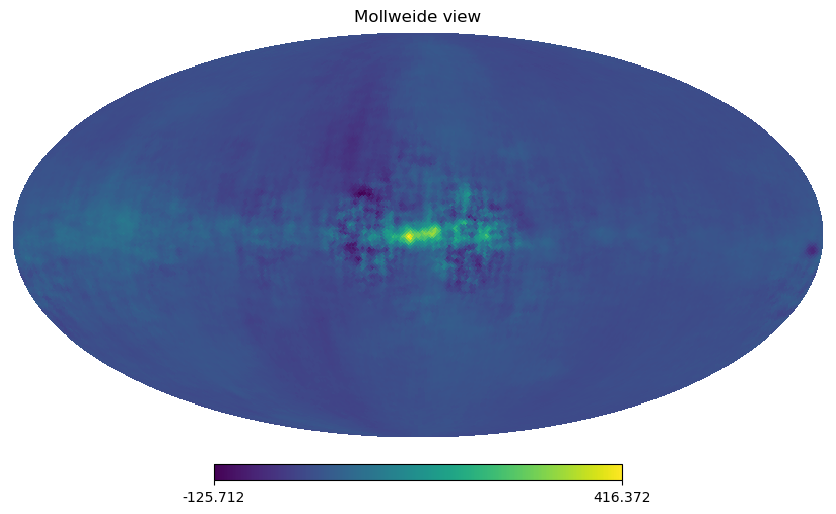

In [4]:
hp.mollview(freq_maps[0,0]) # Freq, nstokes, npix

In [5]:

working_directory_path = '/Users/mag/Documents/PHD1Y/Space_Work/Pixel_non_P2D/MICMAC/test_playground/validation_chain_v5/'
directory_save_file = working_directory_path + 'save_directory/'
directory_toml_file = working_directory_path + 'toml_params/'

# path_toml_file = directory_toml_file + 'biased_full_chain_v1a.toml'
path_toml_file = directory_toml_file + 'biased_full_chain_v1c.toml'

MICMAC_sampler_obj = micmac.create_MICMAC_sampler_from_toml_file(path_toml_file)


In [6]:
path_mask = "/Users/mag/Documents/PHD1Y/Masks/mask_SAT_apodized.fits"

apod_mask = hp.ud_grade(hp.read_map(path_mask),nside_out=MICMAC_sampler_obj.nside)
mask = np.copy(apod_mask)
mask[apod_mask>0] = 1

mask = np.ones(MICMAC_sampler_obj.npix)

MICMAC_sampler_obj.mask = mask

In [7]:
%%time

freq_inverse_noise = MICMAC_sampler_obj.freq_inverse_noise

freq_inverse_noise_masked = np.zeros((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.npix))

nb_pixels_mask = int(mask.sum())
freq_inverse_noise_masked[:,:,mask!=0] = np.repeat(freq_inverse_noise.ravel(order='F'), nb_pixels_mask).reshape((MICMAC_sampler_obj.number_frequencies,MICMAC_sampler_obj.number_frequencies,nb_pixels_mask), order='C')


CPU times: user 36.9 ms, sys: 1.13 ms, total: 38 ms
Wall time: 37.4 ms


In [8]:
MICMAC_sampler_obj.freq_inverse_noise = freq_inverse_noise_masked

In [9]:
MICMAC_sampler_obj.freq_inverse_noise[:,:,mask==0]

array([], shape=(6, 6, 0), dtype=float64)

In [10]:
input_freq_maps, _, theoretical_red_cov_r0_total, theoretical_red_cov_r1_tensor = MICMAC_sampler_obj.generate_input_freq_maps_from_fgs(freq_maps_fgs, return_only_freq_maps=False)

input_freq_maps_masked = input_freq_maps*mask

# Re-Defining the data if needed
indices_polar = np.array([1,2,4])
partial_indices_polar = indices_polar[:MICMAC_sampler_obj.nstokes]


theoretical_r0_total = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r0_total)#[partial_indices_polar,:]
theoretical_r1_tensor = micmac.get_c_ells_from_red_covariance_matrix(theoretical_red_cov_r1_tensor)#[partial_indices_polar,:]


c_ell_approx = np.zeros((3,MICMAC_sampler_obj.lmax+1))
c_ell_approx[0,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[0,:]
c_ell_approx[1,MICMAC_sampler_obj.lmin:] = theoretical_r0_total[1,:]

# Params mixing matrix
init_mixing_matrix_obj = micmac.InitMixingMatrix(MICMAC_sampler_obj.frequency_array, MICMAC_sampler_obj.number_components, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)
exact_params_mixing_matrix = init_mixing_matrix_obj.init_params()

mixing_matrix_obj = micmac.MixingMatrix(MICMAC_sampler_obj.frequency_array, MICMAC_sampler_obj.number_components, exact_params_mixing_matrix, pos_special_freqs=MICMAC_sampler_obj.pos_special_freqs)

mixing_matrix_sampled = mixing_matrix_obj.get_B()

BtinvNB = micmac.get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, mixing_matrix_sampled)
BtinvN_sqrt = micmac.get_BtinvN(np.sqrt(MICMAC_sampler_obj.freq_inverse_noise), mixing_matrix_sampled)

Calculating spectra from CAMB !
Calculating spectra from CAMB !


In [11]:
red_cov_approx_matrix = micmac.get_reduced_matrix_from_c_ell(c_ell_approx)[MICMAC_sampler_obj.lmin:,...]

In [12]:
red_cov_approx_matrix.shape

(127, 2, 2)

In [13]:
lmax = MICMAC_sampler_obj.lmax
n_iter = MICMAC_sampler_obj.n_iter
lmin = MICMAC_sampler_obj.lmin
nstokes = MICMAC_sampler_obj.nstokes
nside = MICMAC_sampler_obj.nside
number_frequencies = MICMAC_sampler_obj.number_frequencies
npix = MICMAC_sampler_obj.npix


In [14]:
jax_key_PNRG = jax.random.PRNGKey(MICMAC_sampler_obj.seed+10)

In [15]:
%%time

map_random_x = None
map_random_y = None
eta_maps = MICMAC_sampler_obj.get_sampling_eta_v2(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


Recalculating x !
Recalculating y !
CPU times: user 3.44 s, sys: 385 ms, total: 3.83 s
Wall time: 2.59 s


In [16]:
jitted_sampling_eta = jax.jit(MICMAC_sampler_obj.get_sampling_eta_v2, static_argnames=['suppress_low_modes'])

In [17]:
%%time
eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


Recalculating x !
Recalculating y !
CPU times: user 1.5 s, sys: 152 ms, total: 1.65 s
Wall time: 1.03 s


In [18]:
%%time
eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


CPU times: user 439 ms, sys: 55.3 ms, total: 494 ms
Wall time: 162 ms


In [19]:
# %%time
# eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


In [20]:
# %%time
# eta_maps = jitted_sampling_eta(red_cov_approx_matrix, BtinvNB, BtinvN_sqrt, jax_key_PNRG, map_random_x=map_random_x, map_random_y=map_random_y, suppress_low_modes=True)


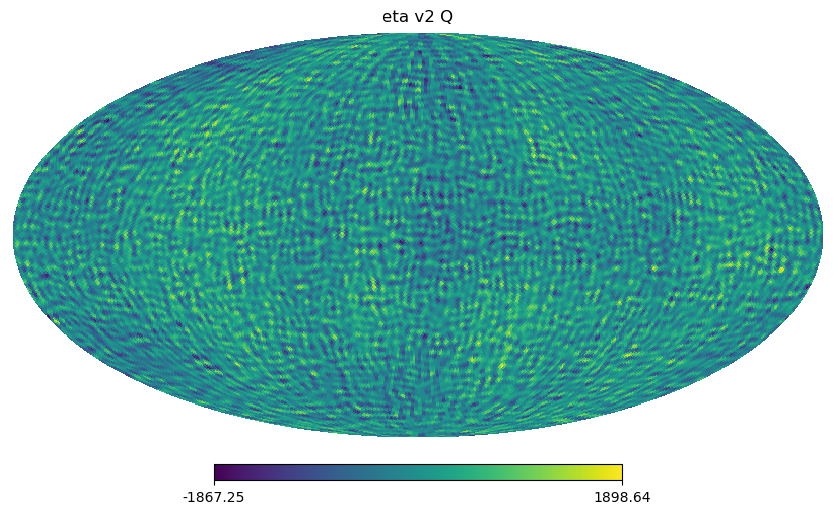

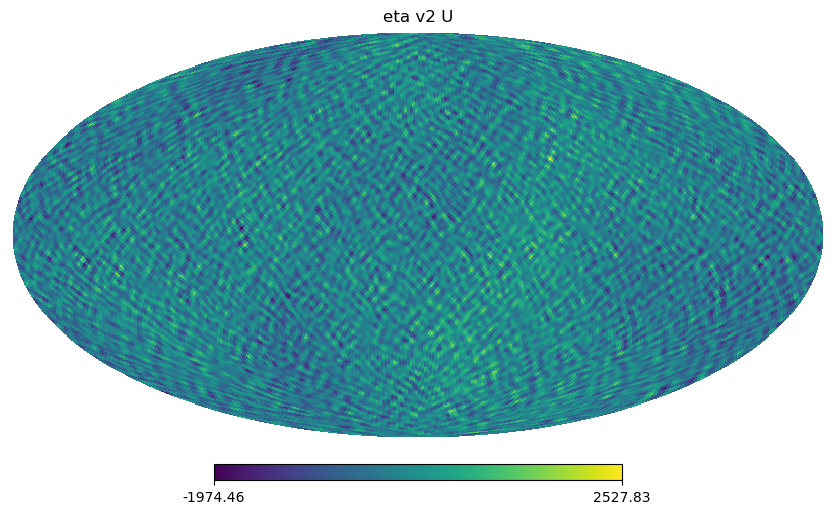

In [21]:
hp.mollview(eta_maps[0], title='eta v2 Q')
hp.mollview(eta_maps[1], title='eta v2 U')

In [22]:
eta_maps_extended = np.vstack([np.zeros_like(eta_maps[0]), eta_maps])
c_ells_eta = hp.anafast(eta_maps_extended, lmax=lmax, iter=n_iter)[indices_polar,lmin:]

In [23]:
_cl_noise_harm = micmac.get_Cl_noise(np.array(instrument['depth_p']), mixing_matrix_sampled, MICMAC_sampler_obj.lmax)[0,0,lmin:]

red_cl_noise_harm = micmac.get_reduced_matrix_from_c_ell(np.array([_cl_noise_harm,_cl_noise_harm,np.zeros_like(_cl_noise_harm)]))


In [24]:
red_cov_approx_matrix_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix))
red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)

red_cl_noise_harm_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cl_noise_harm)
red_cl_noise_harm_msqrt = np.linalg.pinv(micmac.get_sqrt_reduced_matrix_from_matrix(red_cl_noise_harm))

analytical_eta_term_cov = np.einsum('lij,ljk,lkm->lim', red_cov_approx_matrix_sqrt, np.linalg.pinv(red_cov_approx_matrix) + np.linalg.pinv(red_cl_noise_harm), red_cov_approx_matrix_sqrt)
analytical_eta_term_2 = np.zeros_like(c_ell_approx)
analytical_eta_term_2[:,lmin:] = micmac.get_c_ells_from_red_covariance_matrix(analytical_eta_term_cov)


In [25]:
number_correl_to_plot = int(np.ceil(nstokes**2/2) + np.floor(nstokes/2))

if nstokes == 3:
    number_subplots_convention = 421
    figsize = (10,10)
    figsize_big = (12,12)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)
elif nstokes == 2:
    number_subplots_convention = 131
    figsize = (14,6)
    figsize_big = figsize
    position_legend = number_correl_to_plot-1
    bbox_to_anchor=(1, 1)
else:
    number_subplots_convention = 111
    figsize = (10,10)
    figsize_big = (10,10)
    position_legend = int(number_correl_to_plot/2)-1
    bbox_to_anchor=(2.2, 1)

In [26]:
fksy = mask.sum()/mask.size
# fksy = 1
print('fksy = ', fksy)

fksy =  1.0


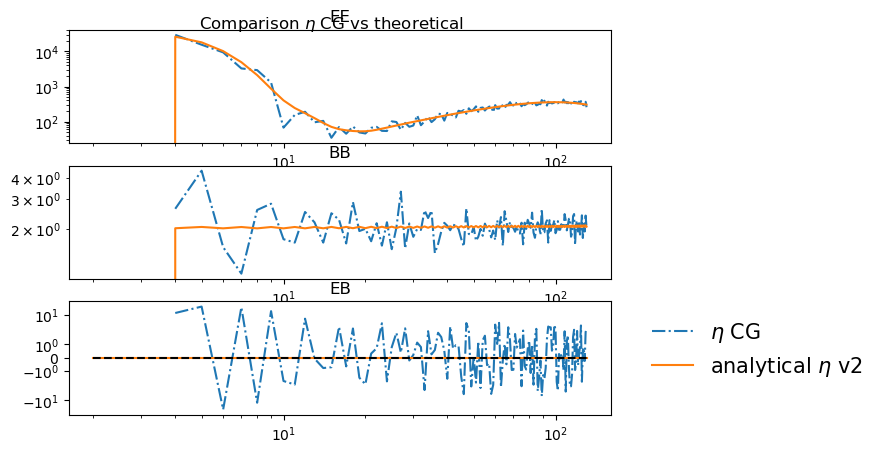

In [27]:
# list_correl = ['TT', 'EE', 'BB', 'TE', 'EB', 'TB']
list_correl = ['EE', 'BB', 'EB']

ell_arange = np.arange(c_ell_approx.shape[1]) + lmin

plt.figure(figsize=(7,5))
plt.suptitle(r"Comparison $\eta$ CG vs theoretical", y=0.91)

for j in range(number_correl_to_plot):
    ax = plt.subplot(311+j)
    plt.title(list_correl[j])

    # plt.plot(ell_arange, c_ell_approx.T[:,j], label='c_ell_approx')
    plt.plot(ell_arange[lmin:], c_ells_eta[j,:]/fksy, '-.', label=r"$\eta$ CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_overrel[j,:]/fksy, '-.', label=r"Overrelax $\eta$ CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_v1[j,:]/fksy, '-.', label=r"$\eta$ v1 CG")
    # plt.plot(ell_arange[lmin:], c_ells_eta_overrel_v1[j,:]/fksy, '-.', label=r"Overrelax v1 $\eta$ CG")

    # plt.plot(ell_arange, analytical_eta_term[j,:], '-.', label=r"analytical $\eta$")
    plt.plot(ell_arange, analytical_eta_term_2[j,:], label=r"analytical $\eta$ v2")
    # plt.plot(ell_arange[lmin:], 1/_cl_noise_harm, '-.', label=r"$N_c$")
    # plt.plot(ell_arange[lmin:], 1/theoretical_r0_total[j,:], label='C_approx')
    # if j < nstokes:
    #     plt.plot([ell_arange[0], ell_arange[-1]], [1,1], '--', color='black')
    # plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')
    if nstokes == 3 and j < number_correl_to_plot-2:
        plt.xticks(color='w')

    if j <= nstokes-1:
        plt.loglog()
        # plt.ylim(ymin=noise_level/10.)
    else:
        plt.xscale('log')
        plt.yscale('symlog')
    # plt.legend()
    if j == position_legend:
        plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", prop={'size': 15}, frameon=False)
        plt.plot([ell_arange[0], ell_arange[-1]], [0,0], '--', color='black')


plt.show()

In [28]:
N_c_inv = jnp.copy(BtinvNB[0,0])
N_c_inv = N_c_inv.at[...,mask!=0].set(1/BtinvNB[0,0,mask!=0]/hp.nside2resol(nside)**2)

product_1 = np.einsum('cfp,ckp->fkp', BtinvN_sqrt, BtinvNB)#*N_c_inv

product_2 = np.einsum('ckp,kfp->cfp', BtinvNB, BtinvN_sqrt)

In [29]:
print(np.einsum('fkp,cfp->ckp', product_1, product_2)[:,:,100]/BtinvNB[0,0,100])
print(np.einsum('cfp,fkp->ckp', product_2, product_1)[:,:,100]/BtinvNB[0,0,100])


[[  1.          -4.72711814  -3.02899876]
 [ -4.72711814 132.70599784  10.36831334]
 [ -3.02899876  10.36831334  21.6719946 ]]
[[  1.          -4.72711814  -3.02899876]
 [ -4.72711814 132.70599784  10.36831334]
 [ -3.02899876  10.36831334  21.6719946 ]]


# Test func

In [30]:
def get_conditional_proba_correction_likelihood_JAX_v2b(self, complete_mixing_matrix, component_eta_maps, red_cov_approx_matrix, previous_inverse=jnp.empty(0), return_inverse=False):
    """ Get conditional probability of correction term in the likelihood from the full mixing matrix

        The associated conditional probability is given by : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
        Or :
        - (eta^t C_approx^{-1/2} ( C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E) ^{-1}) C_approx^{-1/2} \eta

        Parameters
        ----------
        :param complete_mixing_matrix: full mixing matrix of dimension [component, frequencies]
        :param component_eta_maps: set of eta maps of dimension [component, npix]
        :param red_cov_approx_matrix: covariance matrice approx (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

        Returns
        -------
        :return: computation of correction term to the likelihood
    """

    # Building the correction term to the likelihood : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} \eta

    ## Preparing the mixing matrix and C_approx^{-1/2}
    invBtinvNB = get_inv_BtinvNB(self.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(self.nside)**2        
    red_cov_approx_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix)

    ## Preparing the operator ( C_approx^{-1} + N_c^{-1} )^{-1}
    N_c_inv = jnp.zeros_like(invBtinvNB[0,0])
    N_c_inv = N_c_inv.at[...,self.mask!=0].set(1/invBtinvNB[0,0,self.mask!=0])#/jhp.nside2resol(MICMAC_sampler_obj.nside)**2)
    
    first_part_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), red_cov_approx_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)
    # first_part_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), red_cov_approx_matrix, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)
    
    def second_part_left(x):
        return x.reshape((self.nstokes,self.npix))*N_c_inv

    # third_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), red_cov_approx_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter).ravel()

    func_left_term = lambda x : x.ravel() + first_part_left(second_part_left(first_part_left(x))).ravel()
    # func_left_term = lambda x : first_part_left(x).ravel() + second_part_left(x).ravel()

    ## Computation of ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    initial_guess = jnp.copy(component_eta_maps)

    if previous_inverse.size != 0:
        initial_guess = jnp.copy(previous_inverse)

    right_member = jnp.copy(component_eta_maps)
    # right_member = maps_x_red_covariance_cell_JAX(component_eta_maps.reshape((self.nstokes,self.npix)), jnp.linalg.pinv(red_cov_approx_matrix_sqrt), nside=self.nside, lmin=self.lmin, n_iter=self.n_iter).ravel()
    inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), 
                                                tol=self.tolerance_CG, atol=self.tolerance_CG, maxiter=self.limit_iter_cg_eta)


    # inverse_term = maps_x_red_covariance_cell_JAX(inverse_term_z.reshape((self.nstokes,self.npix)), jnp.linalg.pinv(red_cov_approx_matrix_sqrt), nside=self.nside, lmin=self.lmin, n_iter=self.n_iter).ravel()
    ## Computation of C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    # component_eta_maps_3 = maps_x_red_covariance_cell_JAX(inverse_term.reshape(self.nstokes,self.npix), red_cov_approx_matrix_msqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)

    # And finally eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    # second_term_complete = jnp.einsum('sk,sk', component_eta_maps, inverse_term.reshape(self.nstokes,self.npix))
    if self.restrict_to_mask:
        central_term = self.mask
    else:
        central_term = jnp.ones_like(self.mask)
    second_term_complete = jnp.einsum('sp,p,sp', component_eta_maps, central_term, inverse_term.reshape(self.nstokes,self.npix))
    if return_inverse:
        return -(-0 + second_term_complete)/2.*jhp.nside2resol(self.nside)**2, inverse_term.reshape(self.nstokes,self.npix)
    return -(-0 + second_term_complete)/2.*jhp.nside2resol(self.nside)**2

In [139]:
def get_conditional_proba_correction_likelihood_JAX_v2c(self, complete_mixing_matrix, component_eta_maps, red_cov_approx_matrix, previous_inverse=jnp.empty(0), return_inverse=False):
    """ Get conditional probability of correction term in the likelihood from the full mixing matrix

        The associated conditional probability is given by : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
        Or :
        - (eta^t C_approx^{-1/2} ( C_approx^{-1} + (E^t (B^t N^{-1} B)^{-1} E) ^{-1}) C_approx^{-1/2} \eta

        Parameters
        ----------
        :param complete_mixing_matrix: full mixing matrix of dimension [component, frequencies]
        :param component_eta_maps: set of eta maps of dimension [component, npix]
        :param red_cov_approx_matrix: covariance matrice approx (C_approx) in harmonic domain, dimension [lmin:lmax, nstokes, nstokes]

        Returns
        -------
        :return: computation of correction term to the likelihood
    """

    # Building the correction term to the likelihood : - (eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} \eta

    ## Preparing the mixing matrix and C_approx^{-1/2}
    invBtinvNB = get_inv_BtinvNB(self.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(self.nside)**2        
    red_cov_approx_matrix_sqrt = get_sqrt_reduced_matrix_from_matrix_jax(red_cov_approx_matrix)
    red_cov_approx_matrix_msqrt = jnp.linalg.pinv(red_cov_approx_matrix_sqrt)

    ## Preparing the operator ( C_approx^{-1} + N_c^{-1} )^{-1}
    N_c_inv = jnp.zeros_like(invBtinvNB[0,0])
    N_c_inv = N_c_inv.at[...,self.mask!=0].set(1/invBtinvNB[0,0,self.mask!=0])
    N_c_inv_repeat = jnp.repeat(N_c_inv.ravel(order='C'), self.nstokes).reshape((self.nstokes,self.npix), order='F').ravel()

    N_c_repeat = jnp.repeat(invBtinvNB[0,0].ravel(order='C'), self.nstokes).reshape((self.nstokes,self.npix), order='F').ravel()
    
    first_part_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), red_cov_approx_matrix_sqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter).ravel()
    
    def second_part_left(x):
        # return x.reshape((self.nstokes,self.npix))*N_c_inv
        return x*N_c_inv_repeat

    inv_first_part_term_left = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), red_cov_approx_matrix_msqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter).ravel()

    func_left_term = lambda x : x.ravel() + first_part_left(second_part_left(first_part_left(x))).ravel()

    ## Computation of ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    initial_guess = jnp.copy(component_eta_maps)

    if previous_inverse.size != 0:
        initial_guess = jnp.copy(previous_inverse)

    right_member = jnp.copy(component_eta_maps)
    
    func_lineax = lx.FunctionLinearOperator(func_left_term, jax.ShapeDtypeStruct((MICMAC_sampler_obj.nstokes*MICMAC_sampler_obj.npix,),jnp.float64), tags=(lx.symmetric_tag,lx.positive_semidefinite_tag))

    mask_to_use = jnp.repeat(self.mask.ravel(order='C'), self.nstokes).reshape((self.nstokes,self.npix), order='F').ravel()
    func_norm = lambda x : jnp.linalg.norm((x.reshape((self.nstokes,self.npix))*self.mask).ravel(),ord=2)
    # func_norm = lambda x : jnp.sqrt(jnp.sum((x.reshape((self.nstokes,self.npix)))**2))

    def inv_sqrt_second_part_left(x):
        # return x.reshape((self.nstokes,self.npix))*N_c_inv
        return x*jnp.sqrt(N_c_repeat)

    std_eta = component_eta_maps.std()
    def inv_eta(x):
        # return x/std_eta/BtinvNB[0,0]
        return x/(std_eta**2)

    c_ells_eta = micmac.get_cell_from_map_jax(component_eta_maps, lmax=self.lmax, n_iter=self.n_iter)
    red_inv_c_ell_eta = jnp.linalg.pinv(micmac.get_reduced_matrix_from_c_ell_jax(c_ells_eta)[self.lmin:,...])
    # red_inv_c_ell_eta = micmac.get_reduced_matrix_from_c_ell_jax(c_ells_eta)[self.lmin:,...]

    def inv_eta_harm(x):
        return maps_x_red_covariance_cell_JAX(x.reshape((self.nstokes,self.npix)), red_inv_c_ell_eta, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter).ravel()


    # precond_func = lambda x : x.ravel() - third_part_term_left(second_part_left(first_part_left(x))).ravel()
    # precond_func = lambda x : inv_sqrt_second_part_left(inv_first_part_term_left(x).ravel()).ravel()
    # precond_func = lambda x : inv_eta(x).ravel()
    precond_func = lambda x : inv_eta_harm(x).ravel()

    precond_lineax = lx.FunctionLinearOperator(precond_func, jax.ShapeDtypeStruct((MICMAC_sampler_obj.nstokes*MICMAC_sampler_obj.npix,),jnp.float64), tags=(lx.symmetric_tag,lx.positive_semidefinite_tag))

    CG_obj = lx.CG(rtol=MICMAC_sampler_obj.tolerance_CG, atol=1e-8, max_steps=MICMAC_sampler_obj.limit_iter_cg_eta, norm=func_norm)

    time_start = time.time()
    options_dict = {"y0":initial_guess.ravel()}
    # options_dict = {"y0":initial_guess.ravel(), "precond":precond_lineax}
    
    # inverse_term, number_iterations = jsp.sparse.linalg.cg(func_left_term, right_member.ravel(), x0=initial_guess.ravel(), tol=self.tolerance_CG, atol=self.tolerance_CG, maxiter=self.limit_iter_cg_eta)
    solution = lx.linear_solve(func_lineax, right_member.ravel(), solver=CG_obj, throw=False, options=options_dict)

    inverse_term = solution.value
    print("CG-Python-0 Fluct finished with ", solution.result, solution.stats)
    ## Computation of C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    # component_eta_maps_3 = maps_x_red_covariance_cell_JAX(inverse_term.reshape(self.nstokes,self.npix), red_cov_approx_matrix_msqrt, nside=self.nside, lmin=self.lmin, n_iter=self.n_iter)

    # And finally eta^t C_approx^{-1/2} ( C_approx^{-1} + N_c^{-1} )^{-1} C_approx^{-1/2} eta
    # second_term_complete = jnp.einsum('sk,sk', component_eta_maps, inverse_term.reshape(self.nstokes,self.npix))
    if self.restrict_to_mask:
        central_term = self.mask
    else:
        central_term = jnp.ones_like(self.mask)
    second_term_complete = jnp.einsum('sp,p,sp', component_eta_maps, central_term, inverse_term.reshape(self.nstokes,self.npix))
    if return_inverse:
        return -(-0 + second_term_complete)/2.*jhp.nside2resol(self.nside)**2, inverse_term.reshape(self.nstokes,self.npix)
    return -(-0 + second_term_complete)/2.*jhp.nside2resol(self.nside)**2



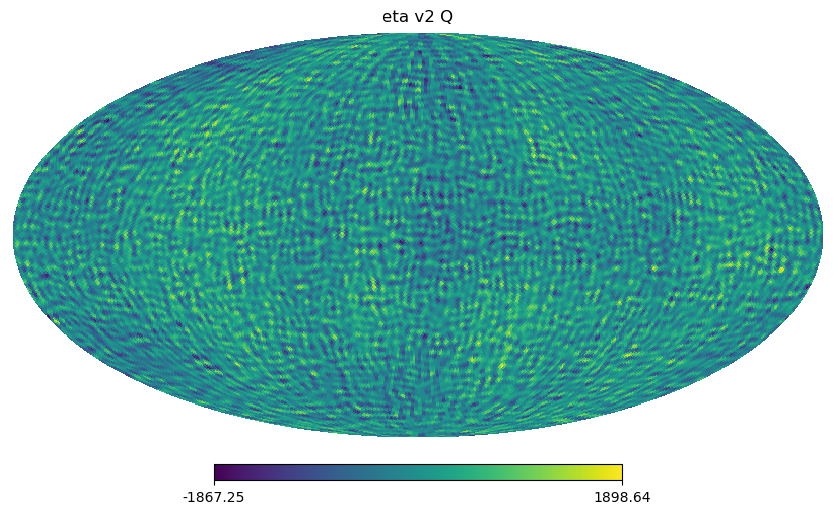

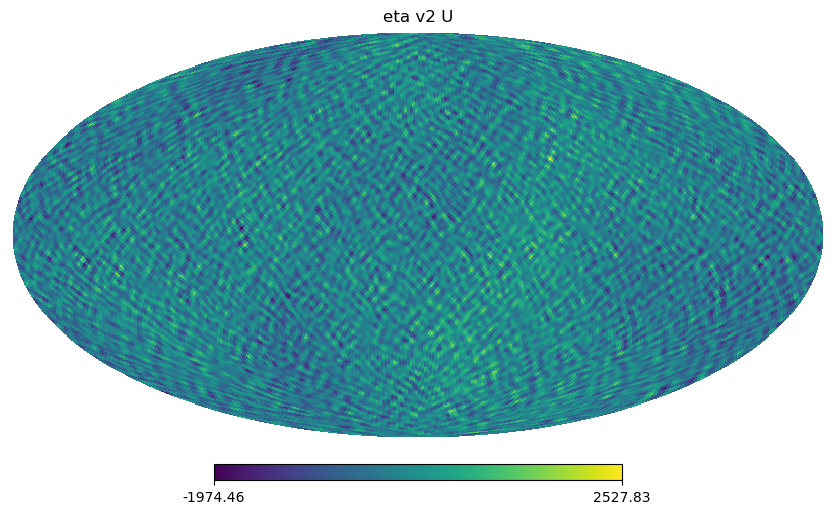

In [51]:
hp.mollview(eta_maps[0], title='eta v2 Q')
hp.mollview(eta_maps[1], title='eta v2 U')

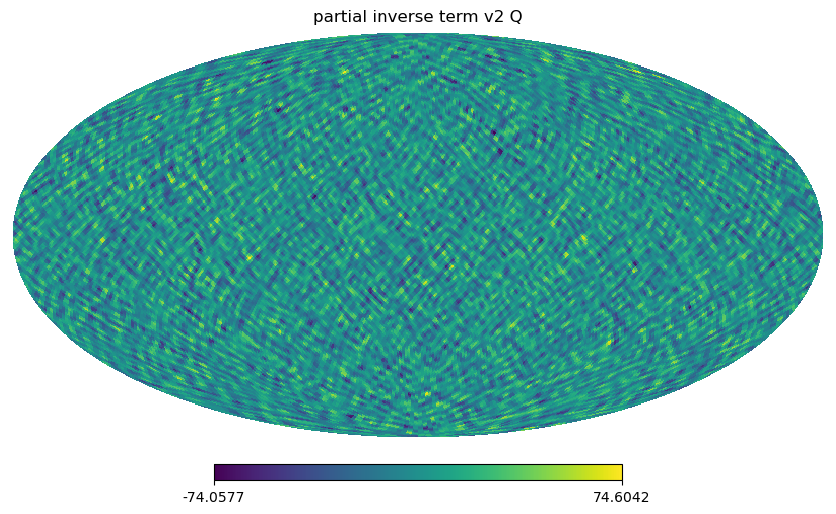

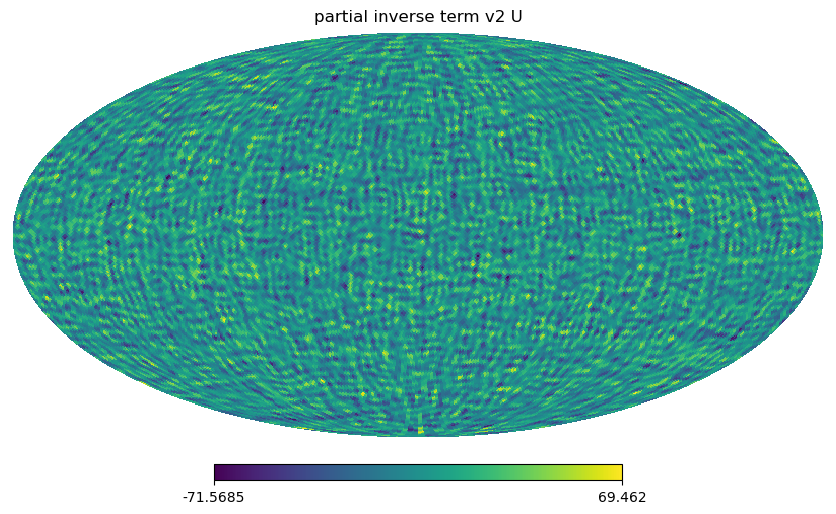

In [50]:
hp.mollview(partial_term_2[0], title='partial inverse term v2 Q')
hp.mollview(partial_term_2[1], title='partial inverse term v2 U')

In [102]:
# test_eta_maps = maps_x_red_covariance_cell_JAX(partial_term_2/np.sqrt(BtinvNB[0,0]), red_cov_approx_matrix_msqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
test_eta_maps = maps_x_red_covariance_cell_JAX(partial_term_2, jnp.linalg.pinv(red_cov_approx_matrix_sqrt), nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

std_eta = eta_maps.std()
test_eta_maps_2 = partial_term_2/std_eta

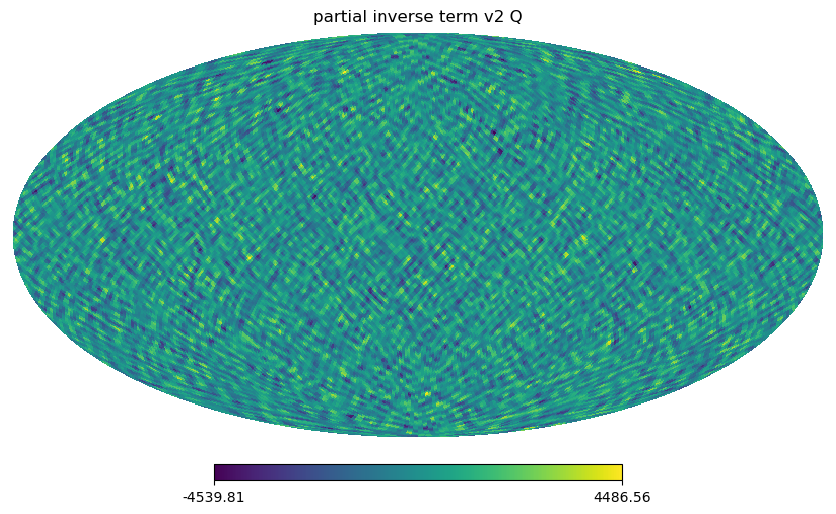

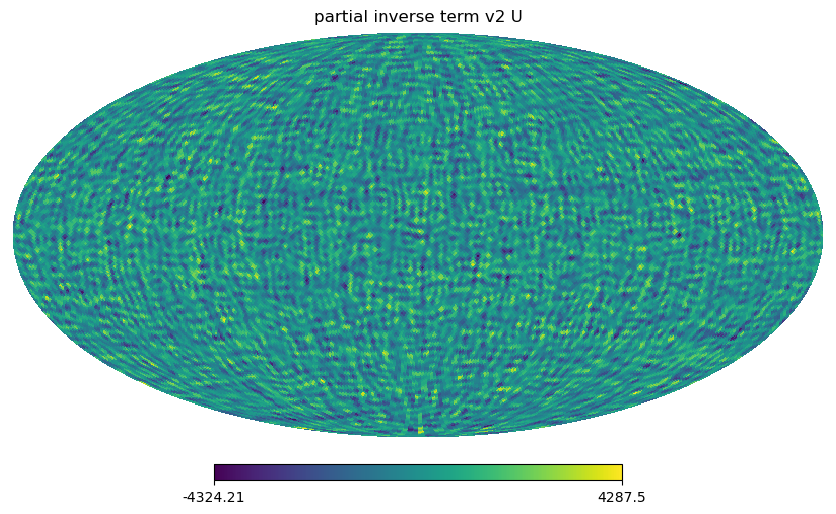

In [77]:
hp.mollview(test_eta_maps[0]*np.sqrt(BtinvNB[0,0]), title='partial inverse term v2 Q')
hp.mollview(test_eta_maps[1]*np.sqrt(BtinvNB[0,0]), title='partial inverse term v2 U')

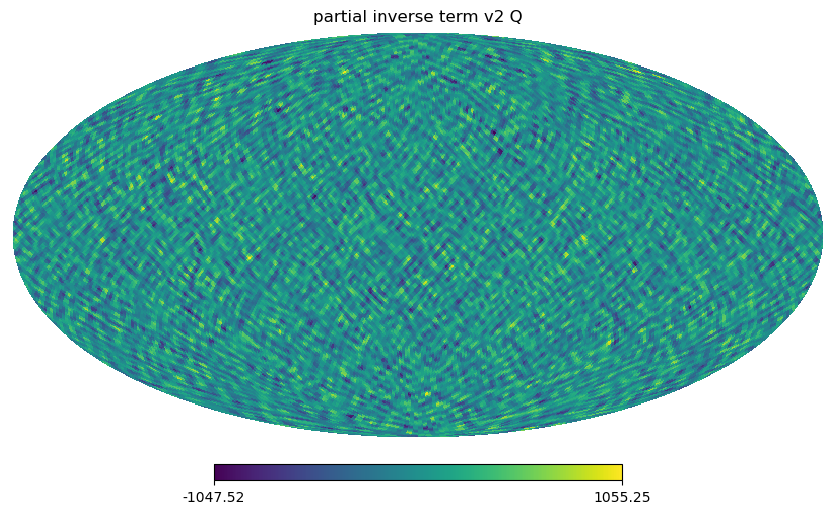

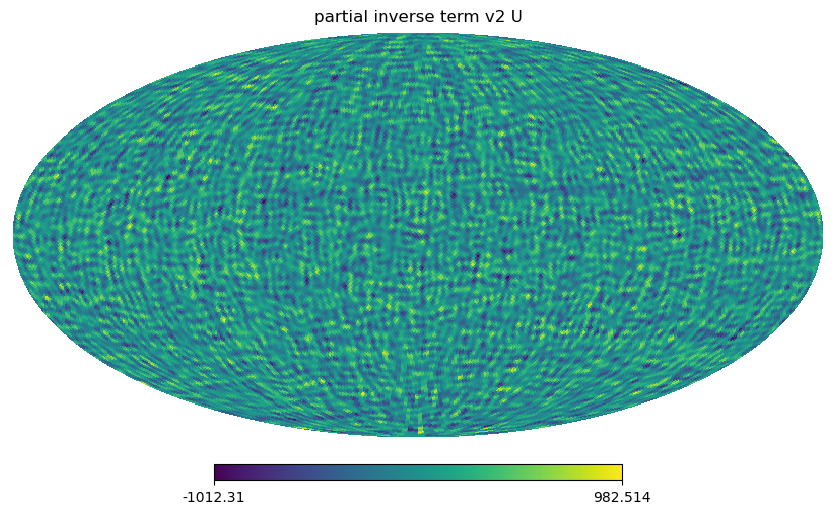

In [68]:
hp.mollview(partial_term_2[0]/np.sqrt(BtinvNB[0,0]), title='partial inverse term v2 Q')
hp.mollview(partial_term_2[1]/np.sqrt(BtinvNB[0,0]), title='partial inverse term v2 U')


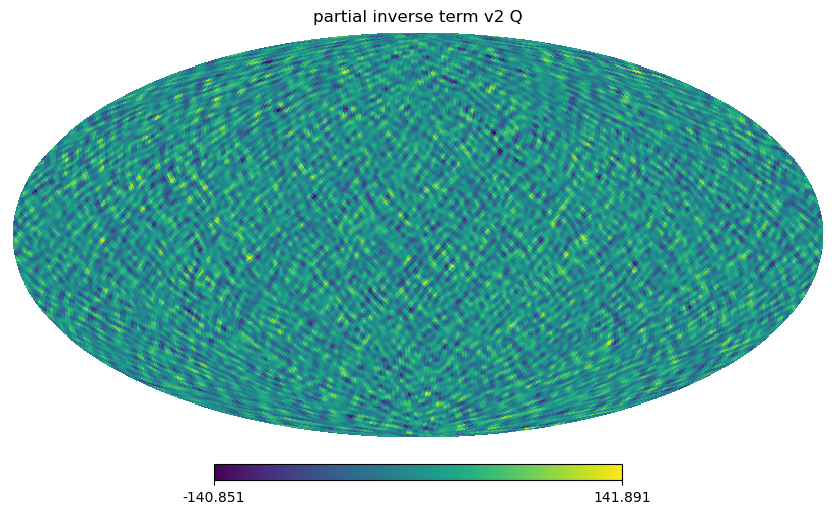

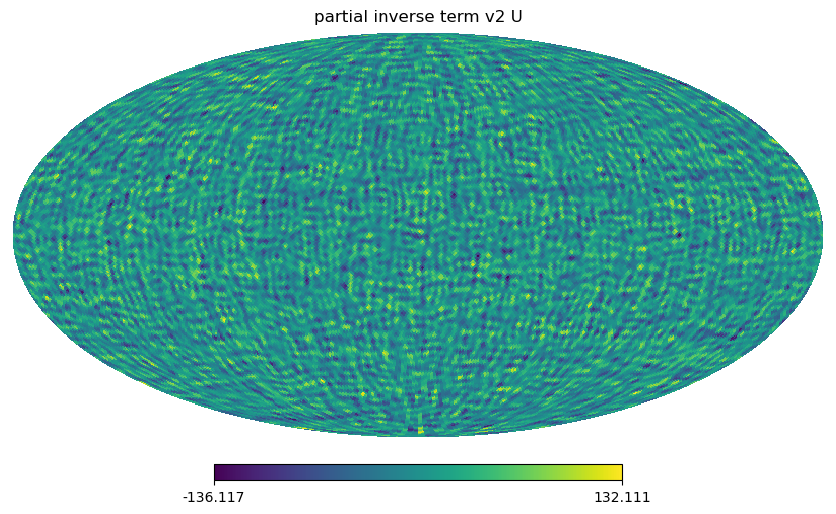

In [109]:
hp.mollview(test_eta_maps_2[0]/np.sqrt(BtinvNB[0,0]*hp.nside2resol(MICMAC_sampler_obj.nside)**2), title='partial inverse term v2 Q')
hp.mollview(test_eta_maps_2[1]/np.sqrt(BtinvNB[0,0]*hp.nside2resol(MICMAC_sampler_obj.nside)**2), title='partial inverse term v2 U')

In [40]:
MICMAC_sampler_obj.limit_iter_cg, MICMAC_sampler_obj.limit_iter_cg_eta

(200, 200.0)

In [32]:
true_mask = mask
fake_mask = np.ones_like(mask)

# MICMAC_sampler_obj.mask = true_mask

In [90]:
MICMAC_sampler_obj.limit_iter_cg_eta = 200
MICMAC_sampler_obj.limit_iter_cg_eta = 2000

In [91]:
%%time

log_proba_1, partial_term_1 = get_conditional_proba_correction_likelihood_JAX_v2b(MICMAC_sampler_obj, mixing_matrix_sampled, eta_maps, red_cov_approx_matrix, 
                                                                                    previous_inverse=jnp.empty(0), return_inverse=True)

CPU times: user 1min 15s, sys: 8.68 s, total: 1min 23s
Wall time: 13.8 s


In [93]:
%%time
log_proba_2, partial_term_2 = get_conditional_proba_correction_likelihood_JAX_v2c(MICMAC_sampler_obj, mixing_matrix_sampled, eta_maps, red_cov_approx_matrix, 
                                                                                    previous_inverse=jnp.empty(0), return_inverse=True)

CG-Python-0 Fluct finished with  lineax._solution.RESULTS<> {'max_steps': 2000, 'num_steps': Array(300, dtype=int64)}
CPU times: user 1min 34s, sys: 10.6 s, total: 1min 45s
Wall time: 18.3 s


In [95]:
%%time
log_proba_2, partial_term_2 = get_conditional_proba_correction_likelihood_JAX_v2c(MICMAC_sampler_obj, mixing_matrix_sampled, eta_maps, red_cov_approx_matrix, 
                                                                                    previous_inverse=jnp.empty(0), return_inverse=True)

CG-Python-0 Fluct finished with  lineax._solution.RESULTS<> {'max_steps': 2000, 'num_steps': Array(300, dtype=int64)}
CPU times: user 1min 34s, sys: 9.88 s, total: 1min 44s
Wall time: 17.3 s


In [141]:
%%time
log_proba_2, partial_term_2 = get_conditional_proba_correction_likelihood_JAX_v2c(MICMAC_sampler_obj, mixing_matrix_sampled, eta_maps, red_cov_approx_matrix, 
                                                                                    previous_inverse=eta_maps/eta_maps.var(), return_inverse=True)

CG-Python-0 Fluct finished with  lineax._solution.RESULTS<> {'max_steps': 2000, 'num_steps': Array(283, dtype=int64)}
CPU times: user 1min 21s, sys: 10.7 s, total: 1min 32s
Wall time: 27.3 s


In [177]:
MICMAC_sampler_obj.limit_iter_cg_eta = 20

In [178]:
%%time
mixing_matrix_sampled_test = mixing_matrix_sampled.copy()
mixing_matrix_sampled_test[1,1] = mixing_matrix_sampled[1,1]*1.1

log_proba_2t, partial_term_2t = get_conditional_proba_correction_likelihood_JAX_v2c(MICMAC_sampler_obj, mixing_matrix_sampled_test, eta_maps, red_cov_approx_matrix, 
                                                                                    previous_inverse=partial_term_2, return_inverse=True)
print(log_proba_2t, log_proba_2)        

CG-Python-0 Fluct finished with  lineax._solution.RESULTS<The maximum number of solver steps was reached. Try increasing `max_steps`.> {'max_steps': 20, 'num_steps': Array(20, dtype=int64)}
-16595.908352713992 -16633.271904304685
CPU times: user 7.07 s, sys: 850 ms, total: 7.92 s
Wall time: 2.84 s


In [176]:
%%time
mixing_matrix_sampled_test = mixing_matrix_sampled.copy()
mixing_matrix_sampled_test[1,1] = mixing_matrix_sampled[1,1]*1.1

log_proba_2t, partial_term_2t = get_conditional_proba_correction_likelihood_JAX_v2c(MICMAC_sampler_obj, mixing_matrix_sampled_test, eta_maps, red_cov_approx_matrix, 
                                                                                    previous_inverse=partial_term_2, return_inverse=True)
print(log_proba_2t, log_proba_2)        

CG-Python-0 Fluct finished with  lineax._solution.RESULTS<> {'max_steps': 1000, 'num_steps': Array(209, dtype=int64)}
-16587.038495512843 -16633.271904304685
CPU times: user 59.8 s, sys: 7.65 s, total: 1min 7s
Wall time: 19.8 s


In [35]:
log_proba_partial_term_1 = -np.einsum('sp,p,sp', eta_maps, MICMAC_sampler_obj.mask, partial_term_1)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2/2
log_proba_partial_term_2 = -np.einsum('sp,p,sp', eta_maps, MICMAC_sampler_obj.mask, partial_term_2)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2/2


In [96]:
def get_eta_term_back(partial_proba_term, complete_mixing_matrix, red_cov_approx_matrix):
    invBtinvNB = get_inv_BtinvNB(MICMAC_sampler_obj.freq_inverse_noise, complete_mixing_matrix, jax_use=True)*jhp.nside2resol(MICMAC_sampler_obj.nside)**2

    red_cov_approx_matrix_sqrt = micmac.get_sqrt_reduced_matrix_from_matrix(red_cov_approx_matrix)
    N_c_inv = jnp.copy(invBtinvNB[0,0])
    N_c_inv = N_c_inv.at[mask!=0].set(1/invBtinvNB[0,0,mask!=0])#/jhp.nside2resol(nside)**2)

    func_1st_term = lambda x : maps_x_red_covariance_cell_JAX(x.reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix), red_cov_approx_matrix_sqrt, nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)

    func_2nd_term_1 = lambda x : maps_x_red_covariance_cell_JAX(x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)), jnp.linalg.pinv(red_cov_approx_matrix), nside=MICMAC_sampler_obj.nside, lmin=MICMAC_sampler_obj.lmin, n_iter=MICMAC_sampler_obj.n_iter)
    func_2nd_term_2 = lambda x : x.reshape((MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix))*N_c_inv

    func_2nd_term = lambda x : (func_2nd_term_1(x) + func_2nd_term_2(x)).ravel()

    total_func = lambda x : func_1st_term(func_2nd_term(func_1st_term(x))).ravel()

    return total_func(partial_proba_term.ravel()).reshape(MICMAC_sampler_obj.nstokes,MICMAC_sampler_obj.npix)



In [97]:
eta_from_partial_1 = get_eta_term_back(partial_term_1, mixing_matrix_sampled, red_cov_approx_matrix)
eta_from_partial_2 = get_eta_term_back(partial_term_2, mixing_matrix_sampled, red_cov_approx_matrix)

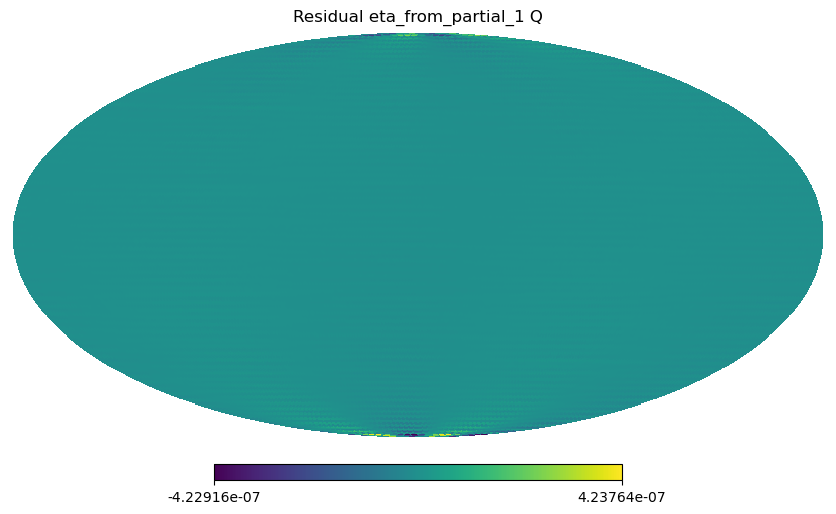

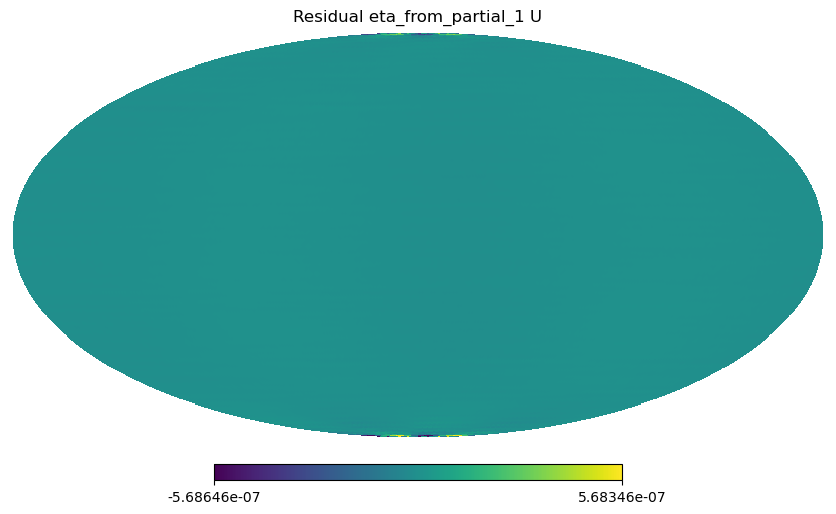

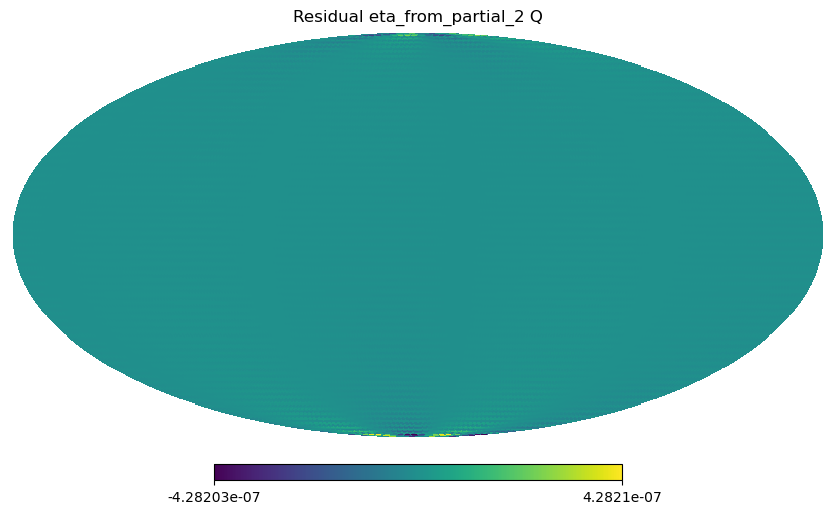

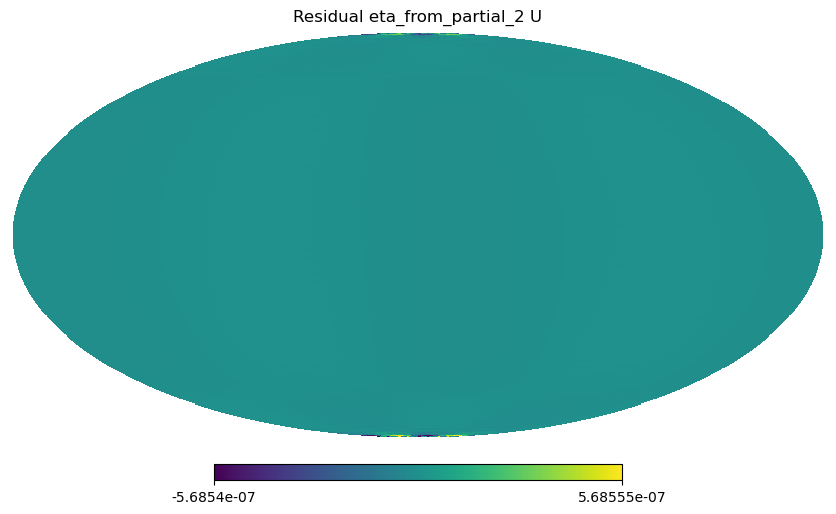

In [98]:
hp.mollview(eta_from_partial_1[0]-eta_maps[0], title='Residual eta_from_partial_1 Q')
hp.mollview(eta_from_partial_1[1]-eta_maps[1], title='Residual eta_from_partial_1 U')
hp.mollview(eta_from_partial_2[0]-eta_maps[0], title='Residual eta_from_partial_2 Q')
hp.mollview(eta_from_partial_2[1]-eta_maps[1], title='Residual eta_from_partial_2 U')